- Cardiovascular diseases (CVDs) is the no.1 causes of human death worldwide according to [pmc article](https://pmc.ncbi.nlm.nih.gov/articles/PMC10809869/).

- Dataset is taken from [Kaggle](https://www.kaggle.com/datasets/neurocipher/heartdisease).

- The goal is to implement Logistic regression model (CLASSIC) to predict heart disease in a patent. 

In [1]:
# Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

#### Step 1: Data preprocessing

In [2]:
# Read dataset file
df = pd.read_csv("data.csv")
df.head(5)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [3]:
# check for any NaN values
df.isna().sum()

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

In [4]:
# Convert Heart Disease into 1 (presence) and 0 (Absence).
df['Heart Disease'] = df['Heart Disease'].map({'Presence': 1, 'Absence': 0})
df.head(5)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


In [5]:
correlation_matrix = df.corr()
print(correlation_matrix['Heart Disease'].sort_values(ascending=False))

Heart Disease              1.000000
Thallium                   0.525020
Number of vessels fluro    0.455336
Exercise angina            0.419303
ST depression              0.417967
Chest pain type            0.417436
Slope of ST                0.337616
Sex                        0.297721
Age                        0.212322
EKG results                0.182091
BP                         0.155383
Cholesterol                0.118021
FBS over 120              -0.016319
Max HR                    -0.418514
Name: Heart Disease, dtype: float64


- From the correlation matrix: it seems when "FBS over 120" or "Max HR increases", the lesser chance of heart disease occuring in a person. Also, "Thallium" seems to be the most critual factor of causing heart disease in a person. 

C:\Users\Zen7\AppData\Local\Temp\ipykernel_22624\1334919867.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([survived_0, survived_1], labels=['No Heart Disease', 'Heart Disease'])


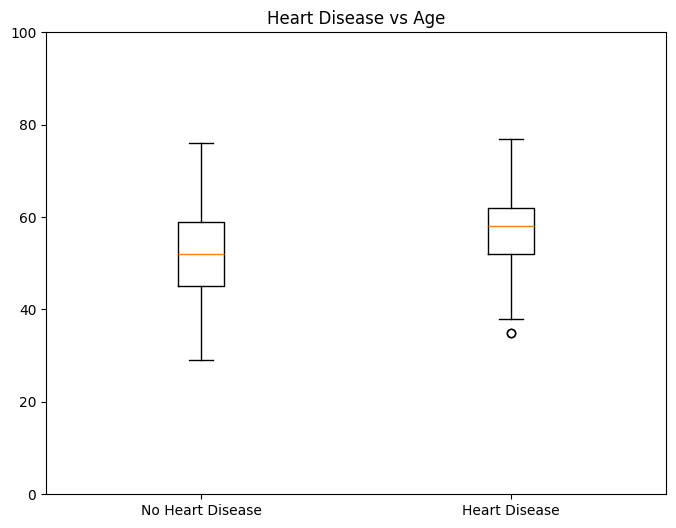

In [6]:
# Boxplot for check for any outliers 
fig, ax=plt.subplots(1,figsize=(8,6))
survived_0 = df[df['Heart Disease'] == 0]['Age']  # Ages of those who did not survive
survived_1 = df[df['Heart Disease'] == 1]['Age']  # Ages of those who survived


ax.boxplot([survived_0, survived_1], labels=['No Heart Disease', 'Heart Disease'])
ax.set_ylim(0,100)
ax.set_ylabel= 'Age'
plt.title("Heart Disease vs Age")
plt.show()

- There is only 1 outlier age in heart disease. Since the age is realistic, we keep this data. 

In [7]:
# Feature and target
X = df.drop('Heart Disease', axis=1) # Include all columns except heart disease
y = df['Heart Disease'] # include heart disease column only

In [8]:
# 80/20 split
train_size = 0.8  # 80% for training
np.random.seed(123)  
shuffle_indices = np.random.permutation(len(df))  # Shuffle the dataset

train_end = int(len(df) * train_size)  # Split index for 80/20 split

X_train = X.iloc[shuffle_indices[:train_end], :]  
X_test = X.iloc[shuffle_indices[train_end:], :] 
y_train = y.iloc[shuffle_indices[:train_end]]  
y_test = y.iloc[shuffle_indices[train_end:]] 

print("X_train:" + str(X_train.shape))  # (216, number of features)
print("y_train:" + str(y_train.shape))  # (216,)
print("X_test:" + str(X_test.shape))   # (54, number of features)
print("y_test:" + str(y_test.shape))   # (54,)

X_train:(216, 13)
y_train:(216,)
X_test:(54, 13)
y_test:(54,)


- 216 train examples, 13 train features.
- 54 test examples, 13 test features. 

In [23]:
# Standardization

# select continuous columns, not binary ones (1 and 0)
columns_to_standardize = ['Cholesterol', 'Max HR', 'ST depression', 'BP']  

# 1. Find mean and std deviation 
mean = X_train[columns_to_standardize].mean()  # Compute the mean for the selected columns
std_dev = X_train[columns_to_standardize].std()  # Compute the standard deviation for the selected columns

# 2. Standardizing the training data  
X_train_std = X_train.copy()  # Avoid modifying the original DataFrame
X_train_std[columns_to_standardize] = (X_train[columns_to_standardize] - mean) / std_dev

# 3. Standardizing the test data using the training set statistics
X_test_std = X_test.copy()   
X_test_std[columns_to_standardize] = (X_test[columns_to_standardize] - mean) / std_dev

print(X_train_std.head())

     Age  Sex  Chest pain type        BP  Cholesterol  FBS over 120  \
30    57    1                3 -0.229489    -0.422649             0   
239   52    1                2 -0.674060     1.389604             0   
120   49    1                3 -0.674060    -1.196633             0   
29    71    0                3 -1.229774     0.256946             1   
196   58    0                4 -1.785487    -0.063974             0   

     EKG results    Max HR  Exercise angina  ST depression  Slope of ST  \
30             2  0.020837                0      -0.586606            2   
239            0  0.982185                0      -0.756911            1   
120            0 -0.459837                0       0.775833            2   
29             2 -0.853115                0      -0.927215            1   
196            2 -1.202697                0      -0.075691            2   

     Number of vessels fluro  Thallium  
30                         1         7  
239                        0         3  

In [24]:
# Force NumPy Array format
X_train_std = X_train_std.to_numpy()
X_test_std  = X_test_std.to_numpy()
y_train = y_train.to_numpy()
y_test  = y_test.to_numpy()
print(type(X_train_std))

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [27]:
m, n = X_train.shape
assert X_train_std.shape[1] == w.shape[0]
assert X_test_std.shape[1] == w.shape[0]

NameError: name 'w' is not defined

#### Step 2: Train Model
- Using reguarized logistic regression.
    - The cost formula is:
    $$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$


In [49]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
          
    ### START CODE HERE ### 
    z = np.clip(z, -500, 500) # prevents numerical too large (overflow) / too small (underflow)
    g = 1 / (1 + np.exp(-z))
    ### END SOLUTION ###  
    
    return g

In [43]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (ndarray Shape (m, n) data, m examples by n features
      y :    (ndarray Shape (m,))  target value 
      w_in : (ndarray Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)              Initial value of parameter of the model
      cost_function :              function to compute cost
      gradient_function :          function to compute gradient
      alpha : (float)              Learning rate
      num_iters : (int)            number of iterations to run gradient descent
      lambda_ : (scalar, float)    regularization constant
      
    Returns:
      w : (ndarray Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [44]:
def compute_cost(X, y, w, b, *argv):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value 
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model
      *argv : unused, for compatibility with regularized version below
    Returns:
      total_cost : (scalar) cost 
    """
    m, n = X.shape
    
    cost = 0
    for i in range(m):
        z = np.dot(X[i],w) + b
        f_wb = sigmoid(z)
        cost += -y[i]*np.log(f_wb) - (1-y[i])*np.log(1-f_wb)
    total_cost = cost/m

    return total_cost

In [45]:
# UNQ_C3
# GRADED FUNCTION: compute_gradient
def compute_gradient(X, y, w, b, *argv): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value 
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model
      *argv : unused, for compatibility with regularized version below
    Returns
      dj_dw : (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w. 
      dj_db : (scalar)             The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    ### START CODE HERE ### 
    for i in range(m):
        z_wb = 0  # Initialize z_wb to zero for each sample
        for j in range(n): 
            z_wb += X[i, j] * w[j]  # Sum the weighted inputs
        
        z_wb += b  # Add the bias term
        f_wb = 1 / (1 + np.exp(-z_wb))  # Apply the sigmoid function to get the prediction
        
        dj_db_i = f_wb - y[i]  # Gradient of the cost w.r.t. bias for the i-th sample
        dj_db += dj_db_i  # Accumulate the gradient of the cost w.r.t. bias
        
        for j in range(n):
            dj_dw[j] += dj_db_i * X[i, j]  # Accumulate the gradient of the cost w.r.t. each weight
            
    dj_dw /= m  # Average the gradients for weights
    dj_db /= m  # Average the gradient for bias
    ### END CODE HERE ###

        
    return dj_db, dj_dw

In [46]:
# UNQ_C6
def compute_gradient_reg(X, y, w, b, lambda_ = 1): 
    """
    Computes the gradient for logistic regression with regularization
 
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value 
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model
      lambda_ : (scalar,float)  regularization constant
    Returns
      dj_db : (scalar)             The gradient of the cost w.r.t. the parameter b. 
      dj_dw : (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w. 

    """
    dj_db, dj_dw = compute_gradient(X, y, w, b)
    dj_dw += (lambda_ / m) * w
    return dj_db, dj_dw

In [47]:
def compute_cost_reg(X, y, w, b, lambda_):
  """
  Computes the gradient for logistic regression with regularization

  Args:
    X : (ndarray Shape (m,n)) data, m examples by n features
    y : (ndarray Shape (m,))  target value 
    w : (ndarray Shape (n,))  values of parameters of the model      
    b : (scalar)              value of bias parameter of the model
    lambda_ : (scalar,float)  regularization constant
  Returns
    dj_db : (scalar)             The gradient of the cost w.r.t. the parameter b. 
    dj_dw : (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w. 

  """
  m, n = X.shape
  cost = 0.0
  for i in range(m):
      z = np.dot(X[i], w) + b
      f = sigmoid(z)
      f = np.clip(f, 1e-8, 1 - 1e-8)
      cost += -y[i]*np.log(f) - (1-y[i])*np.log(1-f)
  cost = cost / m
  reg_cost = (lambda_ / (2*m)) * np.sum(w**2)
  return cost + reg_cost

In [53]:
# Initialize fitting parameters
np.random.seed(1)
initial_w = np.random.rand(X_train_std.shape[1])-0.5
initial_b = 1.

# Set regularization parameter lambda_ (to prevent overfitting)
lambda_ = 0.1    

# Some gradient descent settings
iterations = 40000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train_std, y_train, initial_w, initial_b, 
                                    compute_cost_reg, compute_gradient_reg, 
                                    alpha, iterations, lambda_)

Iteration    0: Cost     2.77   
Iteration 4000: Cost     0.43   
Iteration 8000: Cost     0.39   
Iteration 12000: Cost     0.37   
Iteration 16000: Cost     0.37   
Iteration 20000: Cost     0.36   
Iteration 24000: Cost     0.36   
Iteration 28000: Cost     0.36   
Iteration 32000: Cost     0.36   
Iteration 36000: Cost     0.36   
Iteration 39999: Cost     0.36   


In [57]:
# Prediction function
def predict(X, w, b):
    # Calculate the linear model output z = w^T * X + b
    z = np.dot(X, w) + b
    
    # Apply sigmoid to get probability
    p = sigmoid(z)
    
    # Convert probability to binary classification (0 or 1)
    return (p >= 0.5).astype(int)

# Example usage on test data (y_test is the standardized training data)
p = predict(y_train, w, b)

# Calculate accuracy on test data
test_accuracy = np.mean(p == y_test) * 100
print(f'Train Accuracy: {train_accuracy:.2f}%')

ValueError: shapes (216,) and (13,) not aligned: 216 (dim 0) != 13 (dim 0)